In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trash-classifier/keras/default/1/garbage_classifier_2025-03-14-01-09.keras
/kaggle/input/garbage-classification/garbage_classification/metal/metal375.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal561.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal341.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal688.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal374.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal427.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal383.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal692.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal560.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal702.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal215.jpg
/kaggle/input/garbage-classification/garba

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Define dataset directory
dataset_path = "/kaggle/input/garbage-classification/garbage_classification"

# Set parameters
img_size = (224, 224)  # Resize all images to 224x224
batch_size = 32

# Load dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 80% training, 20% validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")


Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize pixel values
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Memantau validasi loss
    patience=5,          # Berhenti setelah 5 epoch tanpa peningkatan
    restore_best_weights=True # Mengembalikan bobot terbaik
)

# Show model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,508 (42.61 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping] 
)

from datetime import datetime

# Generate timestamp in the required format
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")

# Create dynamic filename
filename = f"garbage_classifier_{timestamp}.keras"

# Save the model
model.save(filename)

print(f"Model saved as {filename}")


Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - accuracy: 0.4109 - loss: 1.9389 - val_accuracy: 0.6297 - val_loss: 1.1439
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.5845 - loss: 1.2707 - val_accuracy: 0.6661 - val_loss: 1.0550
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.6595 - loss: 1.0547 - val_accuracy: 0.7132 - val_loss: 0.9177
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.7098 - loss: 0.8858 - val_accuracy: 0.7335 - val_loss: 0.8416
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.7473 - loss: 0.7541 - val_accuracy: 0.7628 - val_loss: 0.8004
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.7937 - loss: 0.6287 - val_accuracy: 0.7409 - val_loss: 0.8763
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.8223 - loss: 0.5413 - val_accuracy: 0.7325 - val_loss: 0.9805
Epoch 8/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.8458 - loss: 0.4610 - val_accu

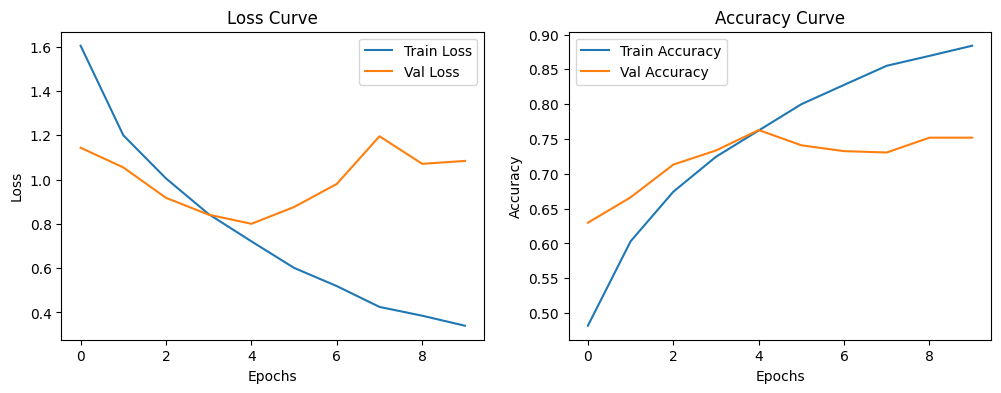

In [7]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [8]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.2f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 612ms/step - accuracy: 0.7508 - loss: 0.8331
Validation Accuracy: 0.76


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


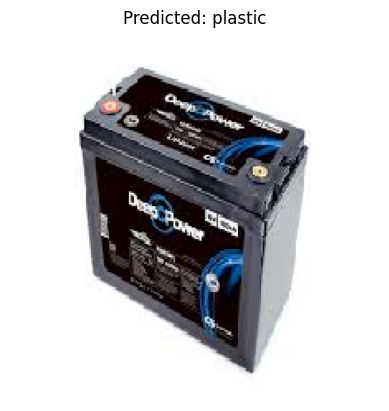

In [9]:
import random
from tensorflow.keras.preprocessing import image

# Pick a random image from validation dataset
img_path = random.choice(os.listdir(os.path.join(dataset_path, class_names[0])))
img_path = os.path.join(dataset_path, class_names[0], img_path)

# Load the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Show the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [10]:
# import tensorflow as tf
# import numpy as np
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt
# import os

# # Load model Keras
# model_path = "/kaggle/input/trash-classifier/keras/default/1"  # Ganti dengan path model Anda
# model = tf.keras.models.load_model(model_path)

# # Label kelas (Ganti sesuai model Anda)
# class_labels = ["Class 1", "Class 2", "Class 3"]  # Sesuaikan dengan kelas sebenarnya

# def preprocess_image(img_path, target_size):
#     """
#     Preprocess gambar untuk inference:
#     - Load gambar
#     - Resize sesuai model
#     - Normalisasi
#     """
#     img = image.load_img(img_path, target_size=target_size)
#     img_array = image.img_to_array(img)  # Konversi ke array numpy
#     img_array = img_array / 255.0  # Normalisasi ke [0,1]
#     img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
#     return img_array, img

# def predict_image(img_path):
#     """
#     Melakukan prediksi pada gambar input dan menampilkan hasilnya.
#     """
#     img_array, img = preprocess_image(img_path, target_size=model.input_shape[1:3])
    
#     # Prediksi menggunakan model
#     predictions = model.predict(img_array)
#     predicted_class = np.argmax(predictions)  # Ambil indeks kelas dengan probabilitas tertinggi
#     confidence = np.max(predictions)  # Ambil nilai probabilitas tertinggi
    
#     # Ambil label kelas
#     predicted_label = class_labels[predicted_class] if predicted_class < len(class_labels) else "Unknown"
    
#     # Tampilkan gambar dan hasil prediksi
#     plt.imshow(img)
#     plt.axis("off")
#     plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
#     plt.show()

#     print(f"Predicted Class: {predicted_label}")
#     print(f"Confidence: {confidence:.4f}")

# # Contoh penggunaan
# image_path = "/kaggle/input/garbage-classification/garbage_classification/battery/battery1.jpg"  # Ganti dengan path gambar input
# predict_image(image_path)
